Combine multiple tdportal reports

In [5]:
import pandas as pd
import glob
import os

# --- Folder path containing your CSV files ---
folder = r"F:\20251115\tdportal"   # ⬅️ change this to your actual folder path

# --- Find all CSV files in the folder ---
csv_files = glob.glob(os.path.join(folder, "*.csv"))

# --- Read each CSV and combine them by row ---
dfs = [pd.read_csv(f) for f in csv_files]
combined = pd.concat(dfs, ignore_index=True)

# --- Save the combined CSV ---
output_path = os.path.join(folder, "combined.csv")
combined.to_csv(output_path, index=False)

print(f"✅ Combined {len(csv_files)} files into {output_path}")

✅ Combined 6 files into F:\20251115\tdportal\combined.csv


Combine multiple h5 files

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Combine multiple HDF5 files with identical structure into a single compressed HDF5.

Expected datasets in each input file:
  - file_name      (N,)        |S59
  - group_name     (N,)        |S6
  - ms2_lib        (N, 1600)   float16
  - precursor_mz   (N,)        float32
  - rt_min         (N,)        float32
  - scan           (N,)        int32

Output:
  - One HDF5 with the same dataset names, concatenated along axis 0,
    stored with gzip compression + shuffle + chunking (npz-like behavior).
"""

import os
import glob
import h5py
import numpy as np

# -----------------------------
# User parameters
# -----------------------------
INPUT_DIR = r"F:\20251115\spectra_h5"      # <-- change this
OUTPUT_FILE = r"F:\20251115\spectra_h5/combined.h5"    # <-- change this
PATTERN = "*.h5"                         # which input files to combine

# I/O chunk size when reading/copying (None = whole file at once; use e.g. 100_000 for huge datasets)
COPY_CHUNK_ROWS = 100_000

# HDF5 dataset compression / chunking
H5_COMPRESSION = "gzip"     # "gzip" is closest to npz; you can use "lzf" for faster but less tight
H5_COMP_OPTS = 4            # 1–9 for gzip, higher = more compression, slower
H5_ROW_CHUNK = 4096         # chunk length along the row axis for HDF5 datasets


# -----------------------------
# Helpers
# -----------------------------
def get_files(input_dir, pattern="*.h5"):
    files = sorted(glob.glob(os.path.join(input_dir, pattern)))
    if not files:
        raise FileNotFoundError(f"No files found in {input_dir!r} matching {pattern!r}")
    return files


def inspect_first_file(example_file):
    """
    Read the first file and capture shapes/dtypes to define the output file.
    Also verifies that required datasets exist.
    """
    expected_keys = ["file_name", "group_name", "ms2_lib",
                     "precursor_mz", "rt_min", "scan"]
    info = {}

    with h5py.File(example_file, "r") as f:
        for k in expected_keys:
            if k not in f:
                raise KeyError(f"Dataset {k!r} not found in {example_file}")
            ds = f[k]
            info[k] = {
                "shape": ds.shape,
                "dtype": ds.dtype,
            }

        # quick consistency checks
        n = info["file_name"]["shape"][0]
        for k in expected_keys:
            if f[k].shape[0] != n:
                raise ValueError(
                    f"Dataset {k!r} in {example_file!r} has first dim "
                    f"{f[k].shape[0]} != file_name first dim {n}"
                )

    return info


def compute_total_rows(files):
    """
    Sum up rows across all files and sanity-check that
    each file has internally consistent first dimensions.
    """
    total = 0
    for fp in files:
        with h5py.File(fp, "r") as f:
            n = f["file_name"].shape[0]
            assert f["group_name"].shape[0] == n
            assert f["ms2_lib"].shape[0] == n
            assert f["precursor_mz"].shape[0] == n
            assert f["rt_min"].shape[0] == n
            assert f["scan"].shape[0] == n
        total += n
    return total


def create_output_file(output_file, first_info, total_rows,
                       compression=H5_COMPRESSION,
                       compression_opts=H5_COMP_OPTS,
                       row_chunk=H5_ROW_CHUNK):
    """
    Create the output HDF5 with compressed, chunked datasets.
    """
    if os.path.exists(output_file):
        os.remove(output_file)

    ms2_dim = first_info["ms2_lib"]["shape"][1]

    f_out = h5py.File(output_file, "w")

    # Chunk shapes
    chunk_scalar = (row_chunk,)
    chunk_ms2 = (row_chunk, ms2_dim)

    d_file_name = f_out.create_dataset(
        "file_name",
        shape=(total_rows,),
        dtype=first_info["file_name"]["dtype"],
        compression=compression,
        compression_opts=compression_opts,
        shuffle=True,
        chunks=chunk_scalar,
    )

    d_group_name = f_out.create_dataset(
        "group_name",
        shape=(total_rows,),
        dtype=first_info["group_name"]["dtype"],
        compression=compression,
        compression_opts=compression_opts,
        shuffle=True,
        chunks=chunk_scalar,
    )

    d_ms2_lib = f_out.create_dataset(
        "ms2_lib",
        shape=(total_rows, ms2_dim),
        dtype=first_info["ms2_lib"]["dtype"],
        compression=compression,
        compression_opts=compression_opts,
        shuffle=True,
        chunks=chunk_ms2,
    )

    d_precursor_mz = f_out.create_dataset(
        "precursor_mz",
        shape=(total_rows,),
        dtype=first_info["precursor_mz"]["dtype"],
        compression=compression,
        compression_opts=compression_opts,
        shuffle=True,
        chunks=chunk_scalar,
    )

    d_rt_min = f_out.create_dataset(
        "rt_min",
        shape=(total_rows,),
        dtype=first_info["rt_min"]["dtype"],
        compression=compression,
        compression_opts=compression_opts,
        shuffle=True,
        chunks=chunk_scalar,
    )

    d_scan = f_out.create_dataset(
        "scan",
        shape=(total_rows,),
        dtype=first_info["scan"]["dtype"],
        compression=compression,
        compression_opts=compression_opts,
        shuffle=True,
        chunks=chunk_scalar,
    )

    dsets_out = {
        "file_name": d_file_name,
        "group_name": d_group_name,
        "ms2_lib": d_ms2_lib,
        "precursor_mz": d_precursor_mz,
        "rt_min": d_rt_min,
        "scan": d_scan,
    }

    return f_out, dsets_out


def copy_data(files, dsets_out, chunk_rows=None):
    """
    Concatenate datasets from all input files into output datasets along axis 0.

    If chunk_rows is None:
        - copy each file in one go (simple, more RAM).
    Else:
        - copy in slices of size chunk_rows (safer for huge files).
    """
    offset = 0

    for fp in files:
        with h5py.File(fp, "r") as f_in:
            n_rows = f_in["file_name"].shape[0]
            print(f"Processing {fp} with {n_rows} rows (writing from offset {offset})")

            if chunk_rows is None:
                # Whole file at once
                sl = slice(offset, offset + n_rows)
                dsets_out["file_name"][sl] = f_in["file_name"][...]
                dsets_out["group_name"][sl] = f_in["group_name"][...]
                dsets_out["ms2_lib"][sl] = f_in["ms2_lib"][...]
                dsets_out["precursor_mz"][sl] = f_in["precursor_mz"][...]
                dsets_out["rt_min"][sl] = f_in["rt_min"][...]
                dsets_out["scan"][sl] = f_in["scan"][...]
            else:
                # Chunked copy
                for start in range(0, n_rows, chunk_rows):
                    end = min(start + chunk_rows, n_rows)
                    local_sl = slice(start, end)
                    global_sl = slice(offset + start, offset + end)

                    dsets_out["file_name"][global_sl] = f_in["file_name"][local_sl]
                    dsets_out["group_name"][global_sl] = f_in["group_name"][local_sl]
                    dsets_out["ms2_lib"][global_sl] = f_in["ms2_lib"][local_sl]
                    dsets_out["precursor_mz"][global_sl] = f_in["precursor_mz"][local_sl]
                    dsets_out["rt_min"][global_sl] = f_in["rt_min"][local_sl]
                    dsets_out["scan"][global_sl] = f_in["scan"][local_sl]

        offset += n_rows

    print(f"Done. Total rows written: {offset}")


# -----------------------------
# Main
# -----------------------------
def main():
    files = get_files(INPUT_DIR, PATTERN)
    print(f"Found {len(files)} input files:")
    for f in files:
        print("  -", f)

    first_info = inspect_first_file(files[0])
    total_rows = compute_total_rows(files)
    print(f"Total rows across all files: {total_rows}")

    f_out, dsets_out = create_output_file(OUTPUT_FILE, first_info, total_rows)
    print(f"Created output file: {OUTPUT_FILE}")

    try:
        copy_data(files, dsets_out, chunk_rows=COPY_CHUNK_ROWS)
        print("All data copied successfully.")
    finally:
        f_out.close()
        print("Output file closed.")


if __name__ == "__main__":
    main()


ID import

In [4]:
import re
import numpy as np
import pandas as pd
import h5py
from tqdm import trange


def annotate_h5_with_tdportal(tdportal_csv, in_h5_path, out_h5_path):
    """
    Read tdportal CSV and an input H5 databank, match scans to IDs, and
    write a new H5 file with added annotation datasets:
        - sequence
        - MASS
        - Accession
        - PFR
    
    ALSO PRINTS:
        - number of samples (file names)
        - matched samples vs unmatched samples
        - total scans matched vs unmatched
    """
    # ------------------------------
    # 1) Load tdportal
    # ------------------------------
    tdportal = pd.read_csv(tdportal_csv)

    def str_to_int_list(s):
        """Extract all integers from a string as a list."""
        return [int(x) for x in re.findall(r'\d+', str(s))]

    # Build mapping: (sample_name, scan) -> tdportal row index
    mapping = {}
    samples_in_tdportal = set()

    for i, row in tdportal.iterrows():
        sample = row['File Name']
        samples_in_tdportal.add(sample)
        scans = str_to_int_list(row['Fragment Scans'])
        for sc in scans:
            mapping[(sample, sc)] = i

    # ------------------------------
    # 2) Load input H5 databank
    # ------------------------------
    with h5py.File(in_h5_path, "r") as f:
        file_name = f["file_name"][()]  # (N,)
        scan      = f["scan"][()]      # (N,)

        # decode bytes to str if needed
        def maybe_decode(arr):
            if isinstance(arr[0], (bytes, np.bytes_)):
                return np.array([x.decode("utf-8") for x in arr], dtype=object)
            return arr

        file_name = maybe_decode(file_name)
        scan = scan.astype(int)

        N = len(scan)

        # Pre-allocate outputs
        sequence  = [""] * N
        MASS      = [np.nan] * N
        Accession = [""] * N
        PFR       = [np.nan] * N

        # Statistics tracking
        matched_scan_count = 0
        unmatched_scan_count = 0
        matched_samples = set()
        unmatched_samples = set()

        for i in trange(N, desc="Matching scans"):
            sname = file_name[i]
            sc    = int(scan[i])
            key   = (sname, sc)

            if key in mapping:
                matched_scan_count += 1
                matched_samples.add(sname)

                idx = mapping[key]
                row = tdportal.loc[idx]
                sequence[i]  = str(row.get('Sequence', ""))
                MASS[i]      = float(row.get('Average Mass', np.nan))
                Accession[i] = str(row.get('Accession', ""))
                PFR[i]       = float(row.get('PFR', np.nan))

            else:
                unmatched_scan_count += 1
                unmatched_samples.add(sname)

    # ------------------------------
    # 3) Print statistics
    # ------------------------------
    total_samples = len(np.unique(file_name))

    print("\n===== MATCHING SUMMARY =====")
    print(f"Total samples in H5: {total_samples}")
    print(f"Samples in tdportal: {len(samples_in_tdportal)}")
    print(f"Matched samples:     {len(matched_samples)}")
    print(f"Unmatched samples:   {len(unmatched_samples)}")

    print("----------------------------------")
    print(f"Total scans in H5:   {N}")
    print(f"Matched scans:       {matched_scan_count}")
    print(f"Unmatched scans:     {unmatched_scan_count}")
    print("==================================\n")

    # ------------------------------
    # 4) Write new H5 with annotations
    # ------------------------------
    dt_str = h5py.string_dtype(encoding='utf-8')

    with h5py.File(in_h5_path, "r") as fin, h5py.File(out_h5_path, "w") as fout:
        # Copy datasets
        for name, item in fin.items():
            fout.create_dataset(name, data=item[()], compression="gzip")

        # Add annotation datasets
        fout.create_dataset("sequence",  data=np.array(sequence,  dtype=dt_str))
        fout.create_dataset("MASS",      data=np.array(MASS,      dtype=np.float32))
        fout.create_dataset("Accession", data=np.array(Accession, dtype=dt_str))
        fout.create_dataset("PFR",       data=np.array(PFR,       dtype=np.float32))


# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":
    tdportal_csv = r"F:\20251115\tdportal\combined.csv"
    in_h5_path   = r"F:\20251115\spectra_h5\combined.h5"
    out_h5_path  = r"F:\20251115\spectra_h5\combined_annotated.h5"

    annotate_h5_with_tdportal(tdportal_csv, in_h5_path, out_h5_path)


C:\Users\benja\AppData\Local\Temp\ipykernel_2860\3293070920.py:25: DtypeWarning: Columns (9,10,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  tdportal = pd.read_csv(tdportal_csv)
Matching scans: 100%|██████████| 2202567/2202567 [00:55<00:00, 39615.67it/s] 



===== MATCHING SUMMARY =====
Total samples in H5: 352
Samples in tdportal: 352
Matched samples:     350
Unmatched samples:   352
----------------------------------
Total scans in H5:   2202567
Matched scans:       398060
Unmatched scans:     1804507



Pie chart and distribution

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import time

# =========================
# Load H5 file
# =========================
path = r"F:\20251115\spectra_h5\combined_annotated.h5"

with h5py.File(path, "r") as h5:
    accession = h5["Accession"][:]

# =========================
# Decode bytes → strings
# =========================
accession = np.array([
    x.decode("utf-8") if isinstance(x, bytes) else x
    for x in accession
])

# Remove empty strings
nonempty = accession[accession != ""]

# Count
unique, counts = np.unique(nonempty, return_counts=True)

# Sort descending by count
idx = np.argsort(counts)[::-1]
unique_sorted = unique[idx]
counts_sorted = counts[idx]

# =========================
# PIE CHART (NO labels AT ALL)
# =========================
plt.figure(figsize=(10, 10))
plt.pie(counts_sorted, labels=None, autopct=None, startangle=90)
plt.title("Pie Chart of All Accessions (No Labels)")
plt.tight_layout()
plt.show()

# =========================
# SCATTER PLOT — TOP 50, LOG SCALE
# =========================
topN = 50
top_accessions = unique_sorted[:topN]
top_counts = counts_sorted[:topN]

plt.figure(figsize=(16, 6))
plt.scatter(top_accessions, top_counts, s=80)
plt.plot(top_accessions, top_counts, alpha=0.35)

plt.yscale("log")  # log scale for counts
plt.xticks(rotation=90)
plt.xlabel("Accession")
plt.ylabel("Count (log scale)")
plt.title("Top 50 Most Frequent Accessions — Scatter Plot (Log Y-Scale)")
plt.grid(alpha=0.3, which="both")
plt.tight_layout()
plt.show()

# ==========================================================
# LOOK UP TOP 50 ACCESSIONS IN UNIPROT AND BUILD A TABLE
# ==========================================================

session = requests.Session()
session.headers.update({"User-Agent": "python-requests uniprot-lookup"})

rows = []

for acc, hit_count in zip(top_accessions, top_counts):
    url = f"https://rest.uniprot.org/uniprotkb/{acc}.json"
    try:
        r = session.get(url)
        r.raise_for_status()
        j = r.json()
    except Exception as e:
        print(f"[WARN] Failed UniProt lookup for {acc}: {e}")
        rows.append({
            "accession": acc,
            "hits": int(hit_count),
            "entry_name": None,
            "protein_name": None,
            "description": None,
        })
        continue

    # UniProt entry name (e.g. MYH7_HUMAN)
    entry_name = j.get("uniProtkbId") or j.get("primaryAccession")

    # Recommended protein name
    protein_name = None
    try:
        protein_name = j["proteinDescription"]["recommendedName"]["fullName"]["value"]
    except KeyError:
        protein_name = None

    # Description: take first FUNCTION comment (if present)
    description = None
    for c in j.get("comments", []):
        if c.get("commentType") == "FUNCTION":
            texts = [t.get("value") for t in c.get("texts", []) if t.get("value")]
            if texts:
                description = " ".join(texts)
                break

    rows.append({
        "accession": acc,
        "hits": int(hit_count),       # your "hit number"
        "entry_name": entry_name,
        "protein_name": protein_name,
        "description": description,
    })

    # be polite to the API
    time.sleep(0.1)

# Make DataFrame
df = pd.DataFrame(rows)

print("\nTop 50 accessions with UniProt info:")
print(df.head(20))

# Save table
out_path = r"F:\20251115\spectra_h5\top50_accessions_uniprot.csv"
df.to_csv(out_path, index=False)
print("\nSaved table to:", out_path)


Cumulitive graph


===== CUMULATIVE THRESHOLDS =====
50% reached by: 7 proteins
60% reached by: 16 proteins
70% reached by: 31 proteins
80% reached by: 64 proteins
90% reached by: 139 proteins
95% reached by: 235 proteins
99% reached by: 523 proteins



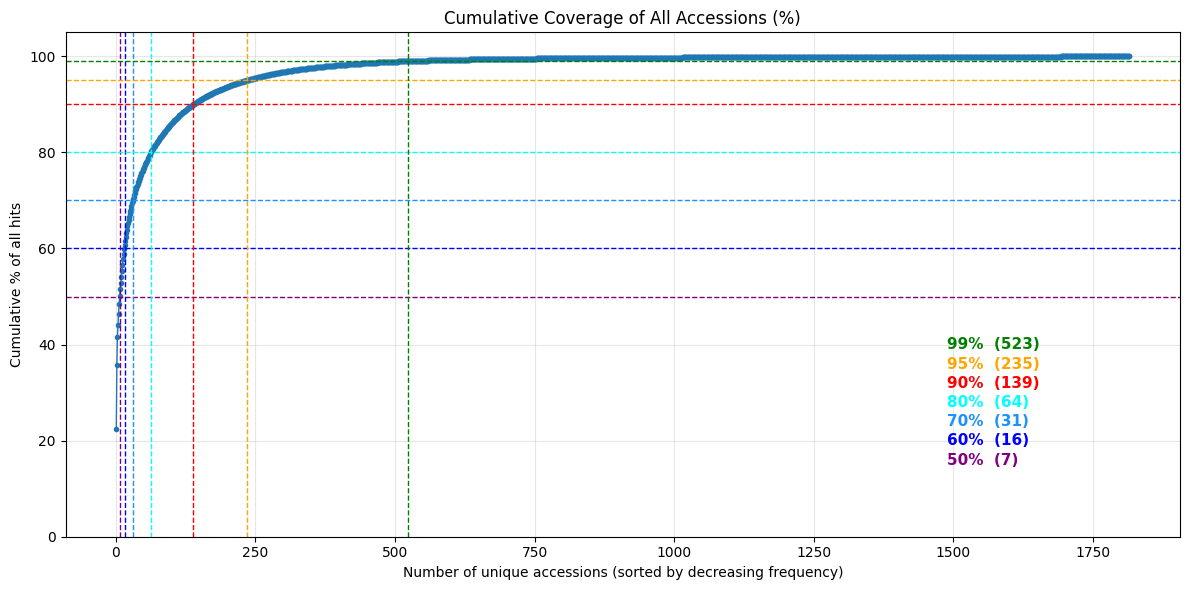

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Load H5 file
# =========================
path = r"F:\20251115\spectra_h5\combined_annotated.h5"

with h5py.File(path, "r") as h5:
    accession = h5["Accession"][:]

# =========================
# Decode bytes → strings
# =========================
accession = np.array([
    x.decode("utf-8") if isinstance(x, bytes) else x
    for x in accession
])

# Remove empty strings
nonempty = accession[accession != ""]

# Count occurrences
unique, counts = np.unique(nonempty, return_counts=True)

# Sort by decreasing count
idx = np.argsort(counts)[::-1]
unique_sorted = unique[idx]
counts_sorted = counts[idx]

# =========================
# Cumulative coverage (%)
# =========================
cum_counts = np.cumsum(counts_sorted)
total_counts = cum_counts[-1]
cum_percent = 100 * cum_counts / total_counts
ranks = np.arange(1, len(cum_percent) + 1)

# =========================
# Threshold function
# =========================
def threshold_index(p):
    i = np.searchsorted(cum_percent, p)
    return i + 1  # convert index to count

# Threshold list
thresholds = [50, 60, 70, 80, 90, 95, 99]
thr_values = {p: threshold_index(p) for p in thresholds}

# Print thresholds
print("\n===== CUMULATIVE THRESHOLDS =====")
for p in thresholds:
    print(f"{p}% reached by: {thr_values[p]} proteins")
print()

# =========================
# Plot
# =========================
plt.figure(figsize=(12, 6))
plt.plot(ranks, cum_percent, marker='.', linewidth=1)

# Horizontal + vertical lines
colors = {
    50: "purple",
    60: "blue",
    70: "dodgerblue",
    80: "cyan",
    90: "red",
    95: "orange",
    99: "green"
}

for p in thresholds:
    # horizontal
    plt.axhline(p, color=colors[p], linestyle='--', linewidth=1)
    # vertical
    plt.axvline(thr_values[p], color=colors[p], linestyle='--', linewidth=1)

# =========================
# LABELS — BOTTOM RIGHT
# =========================
# place labels at ~95% height and near max x
label_x = ranks[-1] * 0.82  # 82% of x-axis width
y_start = 15                 # starting y-position (bottom region)
y_step = 4                   # spacing up

for i, p in enumerate(thresholds):
    y = y_start + i * y_step
    plt.text(label_x, y,
             f"{p}%  ({thr_values[p]})",
             color=colors[p],
             fontsize=11,
             weight='bold')

plt.xlabel("Number of unique accessions (sorted by decreasing frequency)")
plt.ylabel("Cumulative % of all hits")
plt.title("Cumulative Coverage of All Accessions (%)")
plt.ylim(0, 105)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import h5py

path = r"F:\20251115\spectra_h5\combined_annotated.h5"

with h5py.File(path, "r") as h5:
    print("Keys inside the H5 file:")
    for key in h5.keys():
        print(" -", key)


Total scans with MASS > 15000: 166,399
MOST COMMON ACCESSION (MASS > 15000): P68871
Scans for this accession with MASS > 15000: 61,268
MOST COMMON MASS within accession (MASS > 15000): 15867.216


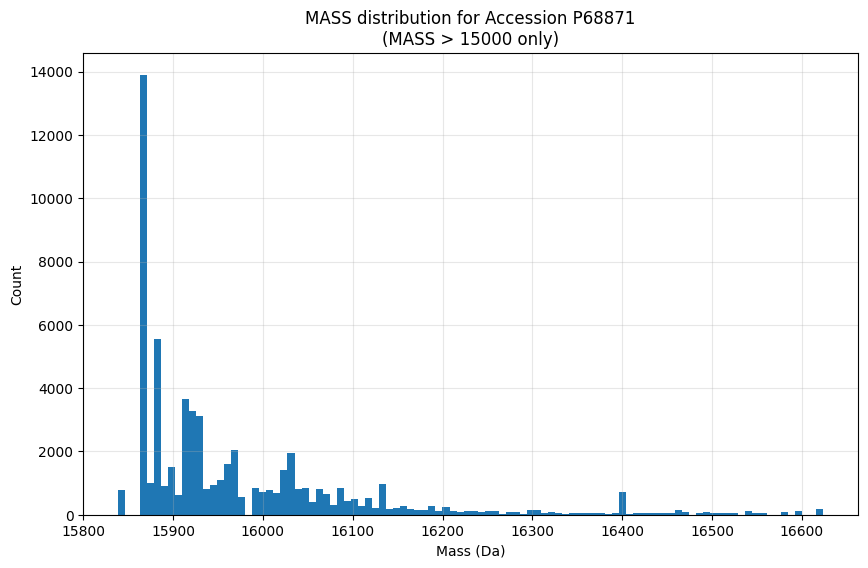

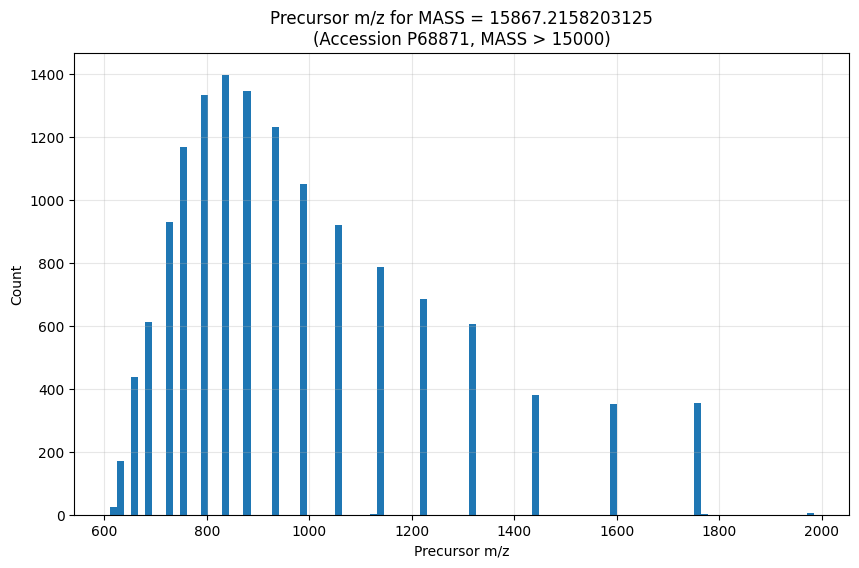


===== SUMMARY =====
Most common accession (MASS > 15000): P68871
Scans for that accession: 61,268
Most common MASS for that accession: 15867.2158203125
Scans with that mass: 13,795


In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# =====================================
# Load H5 file
# =====================================
path = r"F:\20251115\spectra_h5\combined_annotated.h5"

with h5py.File(path, "r") as h5:
    accession = h5["Accession"][:]
    mass = h5["MASS"][:]
    precursor_mz = h5["precursor_mz"][:]

# =====================================
# Decode accession strings
# =====================================
accession = np.array([
    x.decode("utf-8") if isinstance(x, bytes) else x
    for x in accession
])

# =====================================
# Apply MASS > 15000 filter globally
# =====================================
mask_mass_gt15 = mass > 15000
accession_f = accession[mask_mass_gt15]
mass_f = mass[mask_mass_gt15]
precursor_f = precursor_mz[mask_mass_gt15]

# Remove empty accessions
accession_f = accession_f[accession_f != ""]

print(f"Total scans with MASS > 15000: {len(accession_f):,}")

# =====================================
# 1. Find most common accession (after filtering)
# =====================================
unique_acc, counts_acc = np.unique(accession_f, return_counts=True)
most_common_acc = unique_acc[np.argmax(counts_acc)]
print("MOST COMMON ACCESSION (MASS > 15000):", most_common_acc)

# Restrict to this accession
idx_acc = np.where((accession == most_common_acc) & (mass > 15000))[0]
mass_acc = mass[idx_acc]
precursor_acc = precursor_mz[idx_acc]

print(f"Scans for this accession with MASS > 15000: {len(mass_acc):,}")

# =====================================
# 2. Most common MASS > 15000 inside this accession
# =====================================
unique_mass, counts_mass = np.unique(mass_acc, return_counts=True)
most_common_mass = unique_mass[np.argmax(counts_mass)]

print("MOST COMMON MASS within accession (MASS > 15000):", most_common_mass)

# Restrict to this mass
idx_mass = np.where(mass_acc == most_common_mass)[0]
precursor_specific = precursor_acc[idx_mass]

# =====================================
# 3. MASS histogram (restricted to most common accession)
# =====================================
plt.figure(figsize=(10,6))
plt.hist(mass_acc, bins=100)
plt.title(f"MASS distribution for Accession {most_common_acc}\n(MASS > 15000 only)")
plt.xlabel("Mass (Da)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

# =====================================
# 4. Precursor m/z histogram for most common MASS
# =====================================
plt.figure(figsize=(10,6))
plt.hist(precursor_specific, bins=100)
plt.title(f"Precursor m/z for MASS = {most_common_mass}\n(Accession {most_common_acc}, MASS > 15000)")
plt.xlabel("Precursor m/z")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

print("\n===== SUMMARY =====")
print(f"Most common accession (MASS > 15000): {most_common_acc}")
print(f"Scans for that accession: {len(mass_acc):,}")
print(f"Most common MASS for that accession: {most_common_mass}")
print(f"Scans with that mass: {len(idx_mass):,}")


In [5]:
import h5py
import numpy as np
import os

# ============================
# Paths
# ============================
SRC_PATH = r"F:\20251115\spectra_h5\combined_annotated.h5"
OUT_PATH = r"F:\20251115\spectra_h5\filtered_most_common_proteoform_1amu.h5"

# Make sure we don't overwrite accidentally (optional)
if os.path.exists(OUT_PATH):
    print(f"WARNING: {OUT_PATH} already exists and will be overwritten.")
    # If you want to avoid overwrite, uncomment:
    # raise FileExistsError(f"{OUT_PATH} already exists. Choose a new name.")

# ============================
# Step 1: Load minimal data for selection
# ============================
with h5py.File(SRC_PATH, "r") as h5:
    accession_raw = h5["Accession"][:]      # dtype: bytes/object
    mass = h5["MASS"][:]                    # float
    precursor_mz = h5["precursor_mz"][:]    # float

# Decode accessions
accession = np.array([
    x.decode("utf-8") if isinstance(x, bytes) else x
    for x in accession_raw
])

# ============================
# Step 2: Apply MASS > 15000 filter
# ============================
mask_mass_gt15 = mass > 15000

# Also require non-empty accession
mask_valid = mask_mass_gt15 & (accession != "")

valid_acc = accession[mask_valid]

print(f"Total scans in file: {len(accession):,}")
print(f"Scans with MASS > 15000 and non-empty accession: {len(valid_acc):,}")

# ============================
# Step 3: Most common accession among MASS > 15000
# ============================
unique_acc, counts_acc = np.unique(valid_acc, return_counts=True)
most_common_acc = unique_acc[np.argmax(counts_acc)]
print(f"\nMost common accession (MASS > 15000): {most_common_acc}")

# Mask for this accession AND MASS > 15000
mask_acc = (accession == most_common_acc) & mask_mass_gt15

mass_acc = mass[mask_acc]
precursor_acc = precursor_mz[mask_acc]

print(f"Scans for this accession with MASS > 15000: {len(mass_acc):,}")

# ============================
# Step 4: Most common MASS for this accession
# ============================
unique_mass, counts_mass = np.unique(mass_acc, return_counts=True)
most_common_mass = unique_mass[np.argmax(counts_mass)]
print(f"Most common MASS within accession (MASS > 15000): {most_common_mass}")

# Mask for this accession + this mass (+ MASS>15000 implicitly)
mask_acc_mass = mask_acc & (mass == most_common_mass)

precursor_for_mass = precursor_mz[mask_acc_mass]
print(f"Scans for accession {most_common_acc} and MASS {most_common_mass}: {len(precursor_for_mass):,}")

# ============================
# Step 5: Most common precursor m/z for this accession+mass
# ============================
unique_prec, counts_prec = np.unique(precursor_for_mass, return_counts=True)
most_common_precursor = unique_prec[np.argmax(counts_prec)]
print(f"Most common precursor m/z for this accession+mass: {most_common_precursor}")

# -------- 1 amu tolerance here --------
tol_amu = 1.0
final_mask = mask_acc_mass & (np.abs(precursor_mz - most_common_precursor) <= tol_amu)
final_indices = np.where(final_mask)[0]

print(f"\nFINAL SELECTION with ±{tol_amu} amu tolerance: {len(final_indices):,} scans")
print("Summary:")
print(f"  Accession        : {most_common_acc}")
print(f"  MASS             : {most_common_mass}")
print(f"  Center precursor : {most_common_precursor}")
print(f"  Precursor window : [{most_common_precursor - tol_amu}, {most_common_precursor + tol_amu}]")

# Optionally show how many distinct precursor m/z values in the window
unique_prec_in_window = np.unique(precursor_mz[final_indices])
print(f"Distinct precursor m/z values within window: {len(unique_prec_in_window)}")

# ============================
# Step 6: Write filtered H5 file
# ============================
with h5py.File(SRC_PATH, "r") as h5_in, h5py.File(OUT_PATH, "w") as h5_out:
    for key in h5_in.keys():
        dset = h5_in[key]

        # If 1D (length N), index with final_indices
        if dset.ndim == 1:
            data_filtered = dset[final_indices]
        # If 2D (N x something), index on first axis
        elif dset.ndim == 2:
            data_filtered = dset[final_indices, :]
        else:
            raise ValueError(f"Unexpected ndim={dset.ndim} for dataset '{key}'")

        h5_out.create_dataset(
            key,
            data=data_filtered,
            dtype=dset.dtype,
            compression=dset.compression,
            compression_opts=dset.compression_opts,
        )

print(f"\nDONE. New H5 file with 1 amu tolerance written to:\n  {OUT_PATH}")


Total scans in file: 2,202,567
Scans with MASS > 15000 and non-empty accession: 166,399

Most common accession (MASS > 15000): P68871
Scans for this accession with MASS > 15000: 61,268
Most common MASS within accession (MASS > 15000): 15867.2158203125
Scans for accession P68871 and MASS 15867.2158203125: 13,795
Most common precursor m/z for this accession+mass: 992.588623046875

FINAL SELECTION with ±1.0 amu tolerance: 778 scans
Summary:
  Accession        : P68871
  MASS             : 15867.2158203125
  Center precursor : 992.588623046875
  Precursor window : [991.588623046875, 993.588623046875]
Distinct precursor m/z values within window: 689

DONE. New H5 file with 1 amu tolerance written to:
  F:\20251115\spectra_h5\filtered_most_common_proteoform_1amu.h5


MS2 shape: (778, 1600)
m/z axis from 400.0 to 2000.0 with 1600 points
Plotting spectra at indices: [  0 194 388 582 777]


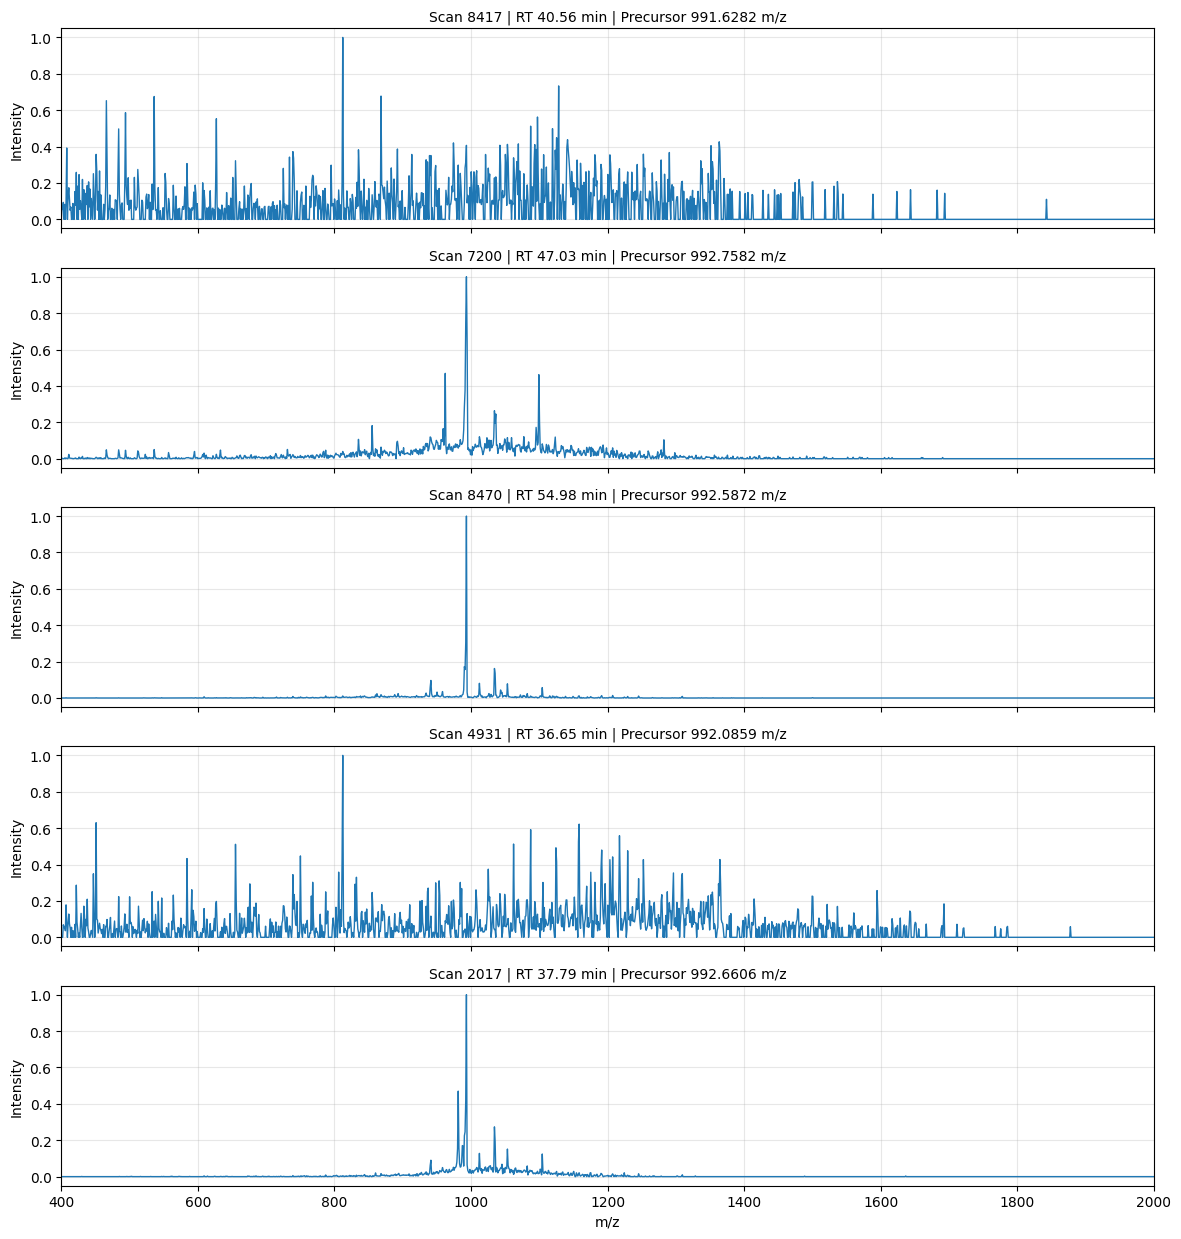

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Path to the filtered H5
# ============================
path_filtered = r"F:\20251115\spectra_h5\common_proteoform.h5"

with h5py.File(path_filtered, "r") as h5:
    ms2 = h5["ms2_lib"][:]          # shape: (N_scans, N_bins)
    precursor_mz = h5["precursor_mz"][:]
    rt_min = h5["rt_min"][:]
    scan = h5["scan"][:]

print("MS2 shape:", ms2.shape)

# ============================
# Build m/z axis: 400–2000 in 1 amu
# ============================
n_bins = ms2.shape[1]
mz_axis = np.linspace(400, 2000, n_bins)

print(f"m/z axis from {mz_axis[0]} to {mz_axis[-1]} with {len(mz_axis)} points")

# ============================
# Select which MS2 to plot
# ============================
n_to_plot = min(5, ms2.shape[0])   
indices = np.linspace(0, ms2.shape[0]-1, n_to_plot, dtype=int)

print("Plotting spectra at indices:", indices)

# ============================
# One spectrum per subplot
# ============================
fig, axes = plt.subplots(n_to_plot, 1, figsize=(12, 2.5*n_to_plot), sharex=True)

if n_to_plot == 1:
    axes = [axes]   # ensure iterable

for ax, idx in zip(axes, indices):
    ax.plot(mz_axis, ms2[idx], linewidth=1)
    ax.set_xlim(400, 2000)
    ax.grid(alpha=0.3)
    ax.set_ylabel("Intensity")

    ax.set_title(
        f"Scan {scan[idx]} | RT {rt_min[idx]:.2f} min | Precursor {precursor_mz[idx]:.4f} m/z",
        fontsize=10
    )

axes[-1].set_xlabel("m/z")
plt.tight_layout()
plt.show()
